<a href="https://colab.research.google.com/github/collvey/Biopython/blob/main/Testing_human_utr_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing

import random
%matplotlib inline
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)

np.random.seed(1337)
import keras

### Plotting settings ###
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2.5
plt.rcParams['xtick.labelsize']= 20
plt.rcParams['ytick.labelsize']= 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['figure.dpi'] = 200
plt.rcParams['lines.linewidth'] = 7
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.minor.size'] = 8
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['axes.edgecolor'] = 'black'

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    #df.loc[:,'obs_stab'] = test_df['stab_df']
    predictions = model.predict(test_seq)
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

#### Load data from the designed library and then select the human UTRs, including the SNVs that were introduced unintenionally from oligo synthesis errors

In [7]:
df = pd.read_csv('./data/GSM3130443_designed_library.csv')

human = df[(df['library'] == 'human_utrs') | (df['library'] == 'snv')]
print('Number of seqs that perfectly match the designed library: ', len(human[human['designed'] == True]))
print('Number of seqs that are 1-3 nucleotides off designed library sequences: ', len(human[human['designed'] == False]))

oh_seqs = one_hot_encode(df=human, col='utr', seq_len=50)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (33,34,35,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Number of seqs that perfectly match the designed library:  23552
Number of seqs that are 1-3 nucleotides off designed library sequences:  27048


#### Load model and predict MRL

In [8]:
retrained_model = keras.models.load_model('./model/retrained_main_MRL_model.hdf5')
human = test_data(df=human, model=retrained_model, test_seq=oh_seqs, obs_col='rl', output_col='retrained_pred')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


#### Select high quality data

In [9]:
human = human.sort_values('total', ascending=False).reset_index(drop=True)
sub = human.iloc[:25000]

#### Plot

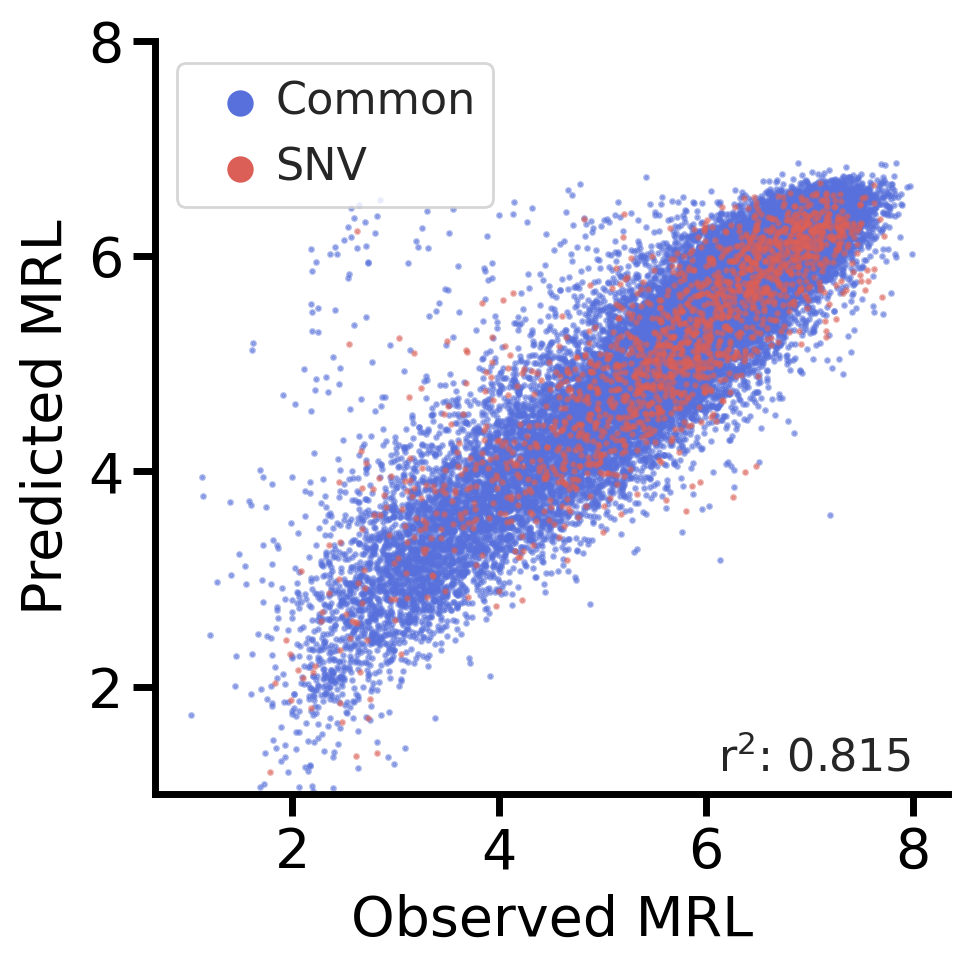

In [10]:
c1 = sns.color_palette("hls", 8)[0]
c2 = sns.color_palette("hls", 8)[5]

r_squared = r2(sub['rl'], sub['retrained_pred'])
all_norm_obs = sub.loc[(sub['library'] == 'human_utrs') | (sub['info4'] == 'normal'), 'rl']
all_norm_pred = sub.loc[(sub['library'] == 'human_utrs') | (sub['info4'] == 'normal'), 'retrained_pred']

variant_obs = sub.loc[sub['info4'] == 'variant', 'rl']
variant_pred = sub.loc[sub['info4'] == 'variant', 'retrained_pred']

f, ax = plt.subplots()
f.set_size_inches((5,5))
ax.scatter(all_norm_obs, all_norm_pred, alpha=0.5, color=c2, label='Common', s=2)
ax.scatter(variant_obs, variant_pred, alpha=0.5, color=c1, label='SNV', s=2)
ax.set_xlabel('Observed MRL', size=20)
ax.set_ylabel('Predicted MRL', size=20)
ax.text(x=.71, y=0.03,s='r$^2$: ' + str(round(r_squared, 3)), transform=ax.transAxes, size=16)
ax.set_ylim((1, 8))
leg = ax.legend(loc='upper left', fontsize=16, handletextpad=-0.2, markerscale=6)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
sns.despine();

# Model Prediction

In [29]:
scaler = preprocessing.StandardScaler()
scaler.fit(human['rl'].values.reshape(-1,1))

input_seq = pd.DataFrame({'utr': ['A'*50, 'C'*50, 'T'*50, 'G'*50]})
input_seq_onehot = one_hot_encode(df=input_seq, col='utr', seq_len=50)
scaled_prediction = scaler.inverse_transform(retrained_model.predict(input_seq_onehot))
scaled_prediction

array([[ 6.6779466 ],
       [ 3.2514706 ],
       [ 6.0857964 ],
       [-0.01090222]], dtype=float32)